In [11]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
from scipy.integrate import odeint
from stable_baselines3 import DDPG
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.noise import NormalActionNoise

class PIDEnv(gym.Env):
    def __init__(self):
        super(PIDEnv, self).__init__()
        
        # Define action and observation space
        self.action_space = spaces.Box(low=np.array([0, 0, 0]), high=np.array([10, 10, 10]), dtype=np.float32)
        self.observation_space = spaces.Box(low=np.array([-np.inf, -np.inf, -np.inf]), 
                                            high=np.array([np.inf, np.inf, np.inf]), dtype=np.float32)
        
        # Initial setpoint and system state
        self.setpoint = 1.0
        self.state = np.array([0.0, 0.0, 0.0])  # [process_variable, integral of error, previous error]
        self.dt = 0.01  # time step
        self.time = np.arange(0, 10, self.dt)  # simulate for 10 seconds
        self.prev_error = 0.0
        self.integral = 0.0
    
    def get_process_variable(self, control_signal):
        # Simulate the DC motor with the given control signal
        def motor_dynamics(y, t, u):
            dydt = (-y + u)  # Simplified first-order model: dy/dt = -y + u
            return dydt
        
        y0 = self.state[0]
        response = odeint(motor_dynamics, y0, [0, self.dt], args=(control_signal,))
        process_variable = response[-1][0]
        
        return process_variable
    
    def compute_control_signal(self, action):
        Kp, Ki, Kd = action
        
        # Compute the error
        error = self.setpoint - self.state[0]
        
        # Compute the integral of error
        self.integral += error * self.dt
        
        # Compute the derivative of error
        derivative = (error - self.prev_error) / self.dt
        
        # PID formula
        control_signal = Kp * error + Ki * self.integral + Kd * derivative
        
        # Update previous error
        self.prev_error = error
        
        return control_signal
    
    def compute_rewards(self, error, control_signal, process_variable):
        reward = -np.sum(np.abs(error)) - 0.1 * np.sum(np.square(np.diff(process_variable)))
        if np.any(process_variable < self.setpoint):
             reward -= 10 * np.sum(self.setpoint - process_variable[process_variable < self.setpoint])
        return reward
    
    def reset(self, seed=None):
        super().reset(seed=seed)
        self.state = np.array([0.0, 0.0, 0.0])
        self.prev_error = 0.0
        self.integral = 0.0
        obs = np.array([self.state[0], self.integral, self.prev_error],dtype=np.float32)
        return obs, {}
    
    def step(self, action):
        control_signal = self.compute_control_signal(action)
        process_variable = self.get_process_variable(control_signal)
        self.state[0] = process_variable
        error = self.setpoint - self.state[0]
        reward = self.compute_rewards(error, control_signal, self.state)
        obs = np.array([self.state[0], self.integral, self.prev_error],dtype=np.float32)
        done = len(self.time) >= 1000  # Stop after 1000 steps
        return obs, reward, done, False, {}
    
    def render(self, mode='human'):
        pass

    def close(self):
        pass


In [17]:

# Create the custom PID environment
env = PIDEnv()

# Check the environment
check_env(env)

# Add action noise for exploration
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# Initialize the DDPG model
model = DDPG("MlpPolicy", env, action_noise=action_noise, verbose=1)

# Train the model
model.learn(total_timesteps=10000)

# Save the model
model.save("ddpg_pid_model")

# Test the trained model
obs ,_s = env.reset()
for _ in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, done,tun, _ = env.step(action)
    if done:
        break


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | -25.3    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 1321     |
|    time_elapsed    | 0        |
|    total_timesteps | 4        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | -26.5    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 1520     |
|    time_elapsed    | 0        |
|    total_timesteps | 8        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | -27.6    |
| time/              |          |
|    episodes        | 12       |
|    fps             |

C:\Users\abhij\AppData\Roaming\Python\Python311\site-packages\stable_baselines3\common\env_checker.py:453: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | -29.1    |
| time/              |          |
|    episodes        | 112      |
|    fps             | 417      |
|    time_elapsed    | 0        |
|    total_timesteps | 112      |
| train/             |          |
|    actor_loss      | 2.37     |
|    critic_loss     | 701      |
|    learning_rate   | 0.001    |
|    n_updates       | 11       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | -29.1    |
| time/              |          |
|    episodes        | 116      |
|    fps             | 347      |
|    time_elapsed    | 0        |
|    total_timesteps | 116      |
| train/             |          |
|    actor_loss      | 3.62     |
|    critic_loss     | 641      |
|    learning_rate   | 0.001    |
|    n_updates       | 15       |
--------------

Final PID constants - Kp: 1.0332479811222437, Ki: 0.0, Kd: 0.0


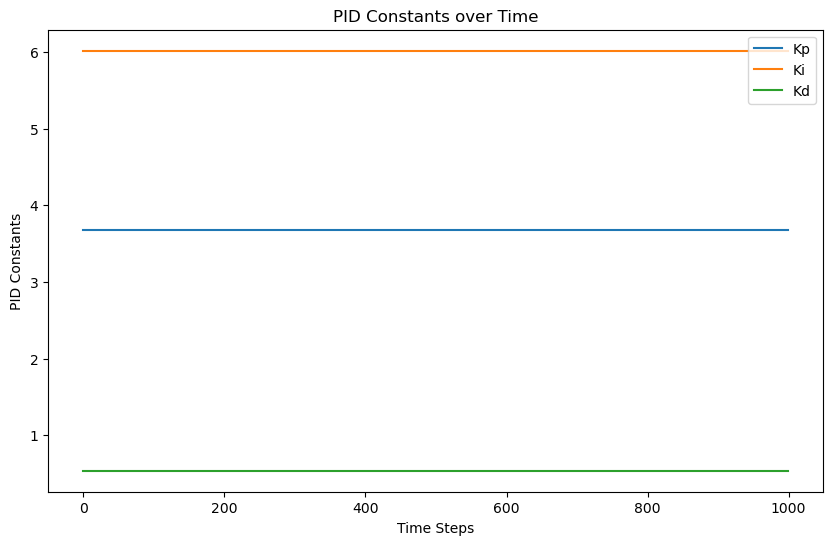

In [20]:
# Visualize the PID constants over time
import matplotlib.pyplot as plt

# Let's see how the PID constants evolve over time
pid_constants = [model.predict(obs)[0] for _ in range(1000)]
pid_constants = np.array(pid_constants)
plt.figure(figsize=(10, 6))
plt.plot(pid_constants[:, 0], label='Kp')
plt.plot(pid_constants[:, 1], label='Ki')
plt.plot(pid_constants[:, 2], label='Kd')
plt.xlabel('Time Steps')
plt.ylabel('PID Constants')
plt.title('PID Constants over Time')
plt.legend()
plt.show()



In [22]:
# Reset the environment to start state
obs,_ = env.reset()

# Get the action (PID constants) predicted by the trained model for the initial observation
final_pid_constants, _ = model.predict(obs, deterministic=True)

# Extract the final PID constants
final_Kp, final_Ki, final_Kd = final_pid_constants

print(f"Final PID Constants after training:")
print(f"Kp: {final_Kp:.4f}, Ki: {final_Ki:.4f}, Kd: {final_Kd:.4f}")

Final PID Constants after training:
Kp: 4.0688, Ki: 5.8862, Kd: 0.9971


In [23]:
import numpy as np
from scipy import signal
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.vec_env import DummyVecEnv

In [40]:
class PIDEnv(gym.Env):
    def __init__(self):
        super(PIDEnv, self).__init__()

        # Define action space (Kp, Ki, Kd)
        self.action_space = gym.spaces.Box(low=np.array([0, 0, 0]), high=np.array([10, 10, 10]), dtype=np.float32)

        # Define observation space
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(2,), dtype=np.float32)

        # PID controller parameters
        self.Kp, self.Ki, self.Kd = 1.0, 1.0, 1.0
        
        # Transfer function G(s) = 1 / (s^2 + 10s + 20)
        num = [0.05]
        den = [3.75e-07, 0.0001252, 5e-05]
        self.G_s = signal.TransferFunction(num, den)

        # Feedback transfer function H(s) = 1 (unity feedback)
        self.H_s = signal.TransferFunction([0.05], [1])

        # Discretize the transfer functions
        self.sample_time = 0.1  # Sample time
        self.G_z = self.G_s.to_discrete(self.sample_time)
        self.H_z = self.H_s.to_discrete(self.sample_time)

        # Setpoint for the system
        self.setpoint = 1.0
        self.state = None  # Initial state

    def reset(self, seed=None, options=None):
        # Seed the environment's RNG
        super().reset(seed=seed)
        
        # Reset the state of the environment to an initial state
        self.state = np.array([0.0, 0.0])  # Example initial state: [output, integral of error]
        return self.state

    def step(self, action):
        # Update the PID parameters
        self.Kp, self.Ki, self.Kd = action

        # Get the current error
        error = self.setpoint - self.state[0]

        # Update the integral of the error for integral action
        integral_error = self.state[1] + error * self.sample_time

        # Calculate the PID control signal
        control_signal = self.Kp * error + self.Ki * integral_error + self.Kd * (error - self.state[1]) / self.sample_time

        # Simulate the system response using the discretized transfer function G(z)
        t, response = signal.dlsim(self.G_z, [control_signal])

        # Update the state with the new output and integral of error
        new_output = response[-1][0]  # Get the last value of the response (new output)
        self.state = np.array([new_output, integral_error])

        # Compute the reward (negative of the absolute error)
        reward = -np.abs(error) - 0.1 * np.sum(np.square(np.diff(response)))
        if(max(response)>self.setpoint*1.01):
            reward += -(max(response)-self.setpoint)

        # Check if the episode is done
        done = False
        if np.abs(error) < 0.01:  # Example condition for done
            done = True

        return self.state, reward, done,False, {}

    def compute_reward(self, error):
        # Reward function can be more complex depending on the application
        return -np.abs(error)


# Create vectorized environment
env = DummyVecEnv([lambda: PIDEnv()])

# DDPG parameters
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# Create the DDPG model
model = DDPG("MlpPolicy", env, action_noise=action_noise, verbose=1)

# Train the model
model.learn(total_timesteps=10000)


Using cpu device


In [41]:

# Get final PID constants after training
obs = env.reset()
final_pid_constants, _ = model.predict(obs, deterministic=True)
final_Kp, final_Ki, final_Kd = final_pid_constants[0]
print(f"Final PID Constants after training: Kp: {final_Kp:.4f}, Ki: {final_Ki:.4f}, Kd: {final_Kd:.4f}")


Final PID Constants after training: Kp: 0.0001, Ki: 10.0000, Kd: 9.9972
